In [1]:
!pip install --upgrade transformers
!pip install --upgrade torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
!pip install --upgrade datasets seqeval evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=47d7b97ceafbb4a74bff72a6616ba0f3caabfcfa0f62831dba0c9a98202b77b7
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2

In [3]:
!pip install evaluate

In [4]:
import numpy as np
from transformers import LayoutLMv3Processor, LayoutLMv3Tokenizer, LayoutLMv3ForTokenClassification
from datasets import load_dataset, Dataset, Features, Sequence, ClassLabel, Value, Array2D, Array3D
import torch
from PIL import Image, ImageDraw, ImageFont
import evaluate
from tqdm.notebook import tqdm

In [5]:
# load drive
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

## Data

In [ ]:
funsd = load_dataset("nielsr/funsd")
id2label = ["O", "B-HEADER", "I-HEADER", "B-QUESTION", "I-QUESTION", "B-ANSWER", "I-ANSWER"]
label2id = {v: k for k, v in enumerate(id2label)}
label2id

{'O': 0,
 'B-HEADER': 1,
 'I-HEADER': 2,
 'B-QUESTION': 3,
 'I-QUESTION': 4,
 'B-ANSWER': 5,
 'I-ANSWER': 6}

## LayoutLMv3

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base", num_labels=len(id2label))


Encode and process train and test set, define features

In [8]:
def encode(examples):
  images = [Image.open(path).convert("RGB") for path in examples['image_path']]
  words = examples['words']
  boxes = examples['bboxes']
  word_labels = examples['ner_tags']

  encoded_inputs = processor(
      images,
      words,
      boxes=boxes,
      word_labels=word_labels,
      padding="max_length",
      truncation=True
  )
  return encoded_inputs

In [9]:
# Using test set for validation, then will use specific examples for inference/interpretability
train_dataset = funsd['train'].map(encode, batched=True, remove_columns=funsd['train'].column_names)
val_dataset = funsd['test'].map(encode, batched=True, remove_columns=funsd['test'].column_names)

columns = ["input_ids", "bbox", "attention_mask", "labels"]
train_dataset.set_format(type="torch", columns=columns)
val_dataset.set_format(type="torch", columns=columns)


Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Metrics

In [10]:
metric = evaluate.load("seqeval")

def compute_metrics(p):
  predictions, labels = p
  predictions = np.argmax(predictions, axis=2)

  true_preds = [
      [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
  ]
  true_labels = [
      [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
  ]
  results = metric.compute(predictions=true_preds, references=true_labels)

  return {
      "precision": results["overall_precision"],
      "recall": results["overall_recall"],
      "f1": results["overall_f1"],
      "accuracy": results["overall_accuracy"],
  }

Fine tuning

In [11]:
from transformers import TrainingArguments, Trainer
output_dir = "./layoutlmv3-finetuned-funsd"
training_args = TrainingArguments(
    output_dir=output_dir,
    max_steps=1000,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-5,
    eval_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

<ipython-input-11-9463f4c22369>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [12]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: a-serag2 (newcastle-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,1.108315,0.410470,0.416791,0.413606,0.620468
200,No log,0.772158,0.589455,0.649776,0.618147,0.729347
300,No log,0.711016,0.635624,0.698460,0.665562,0.743136
400,No log,0.706947,0.678636,0.741679,0.708759,0.764174
500,0.819400,0.711181,0.729177,0.761053,0.744774,0.776774
600,0.819400,0.751159,0.735462,0.766518,0.750669,0.778795
700,0.819400,0.728046,0.754645,0.786885,0.770428,0.791751
800,0.819400,0.733594,0.759602,0.795827,0.777293,0.797932
900,0.819400,0.772253,0.761402,0.787879,0.774414,0.789730
1000,0.291900,0.766144,0.756641,0.792350,0.774084,0.793772


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.5556152191162109, metrics={'train_runtime': 406.227, 'train_samples_per_second': 4.923, 'train_steps_per_second': 2.462, 'total_flos': 523783817001984.0, 'train_loss': 0.5556152191162109, 'epoch': 13.333333333333334})

In [16]:
!zip -r /content/layoutlmv3-finetuned-funsd.zip /content/layoutlmv3-finetuned-funsd
!cp -r /content/layoutlmv3-finetuned-funsd.zip /content/drive/MyDrive/THESIS/LayoutLMv3/Notebook1

  adding: content/layoutlmv3-finetuned-funsd/ (stored 0%)
  adding: content/layoutlmv3-finetuned-funsd/checkpoint-500/ (stored 0%)
  adding: content/layoutlmv3-finetuned-funsd/checkpoint-500/trainer_state.json (deflated 68%)
  adding: content/layoutlmv3-finetuned-funsd/checkpoint-500/config.json (deflated 59%)
  adding: content/layoutlmv3-finetuned-funsd/checkpoint-500/merges.txt (deflated 53%)
  adding: content/layoutlmv3-finetuned-funsd/checkpoint-500/vocab.json (deflated 59%)
  adding: content/layoutlmv3-finetuned-funsd/checkpoint-500/scheduler.pt (deflated 56%)
  adding: content/layoutlmv3-finetuned-funsd/checkpoint-500/special_tokens_map.json (deflated 85%)
  adding: content/layoutlmv3-finetuned-funsd/checkpoint-500/tokenizer_config.json (deflated 75%)
  adding: content/layoutlmv3-finetuned-funsd/checkpoint-500/optimizer.pt (deflated 33%)
  adding: content/layoutlmv3-finetuned-funsd/checkpoint-500/rng_state.pth (deflated 25%)
  adding: content/layoutlmv3-finetuned-funsd/checkpoint

### Inference

In [24]:
!cp -r /content/drive/MyDrive/THESIS/LayoutLMv3/Notebook1/layoutlmv3-finetuned-funsd.zip
!unzip layoutlmv3-finetuned-funsd.zip -d ./inf-data


cp: missing destination file operand after '/content/drive/MyDrive/THESIS/LayoutLMv3/Notebook1/layoutlmv3-finetuned-funsd.zip'
Try 'cp --help' for more information.
Archive:  layoutlmv3-finetuned-funsd.zip
   creating: ./inf-data/content/layoutlmv3-finetuned-funsd/
   creating: ./inf-data/content/layoutlmv3-finetuned-funsd/checkpoint-500/
  inflating: ./inf-data/content/layoutlmv3-finetuned-funsd/checkpoint-500/trainer_state.json  
  inflating: ./inf-data/content/layoutlmv3-finetuned-funsd/checkpoint-500/config.json  
  inflating: ./inf-data/content/layoutlmv3-finetuned-funsd/checkpoint-500/merges.txt  
  inflating: ./inf-data/content/layoutlmv3-finetuned-funsd/checkpoint-500/vocab.json  
  inflating: ./inf-data/content/layoutlmv3-finetuned-funsd/checkpoint-500/scheduler.pt  
  inflating: ./inf-data/content/layoutlmv3-finetuned-funsd/checkpoint-500/special_tokens_map.json  
  inflating: ./inf-data/content/layoutlmv3-finetuned-funsd/checkpoint-500/tokenizer_config.json  
  inflating: ./

In [26]:
checkpoint_path = "/content/inf-data/content/layoutlmv3-finetuned-funsd/checkpoint-1000"
model = LayoutLMv3ForTokenClassification.from_pretrained(checkpoint_path)
processor = LayoutLMv3Processor.from_pretrained(checkpoint_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

In [27]:
sample = funsd['test'][0]
image = Image.open(sample['image_path']).convert("RGB")
words = sample['words']
boxes = sample['bboxes']
word_labels = sample['ner_tags']

In [28]:
inputes = processor(
    image,
    words,
    boxes=boxes,
    return_tensors="pt",
    truncation=True,
    padding="max_length"
)
inputs = {k: v.to(device) for k, v in inputes.items()}


In [29]:
with torch.no_grad():
  outputs = model(**inputs)
  logits = outputs.logits

pred_ids = torch.argmax(logits, dim=-1).squeeze().tolist()
pred_labels = [id2label[pred_id] for pred_id in pred_ids]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [32]:
id2label = model.config.id2label

pred_labels = [id2label[pred] for pred, label in zip(pred_ids, word_labels) if label != -100]
tokens = [word for word, label in zip(words, pred_labels) if label != -100]


In [42]:
import random
from PIL import ImageDraw, ImageFont

def draw_predictions(image, words, boxes, labels, title="Predictions"):
  draw = ImageDraw.Draw(image)

  label_colors = {
    "O": "black",
    "B-HEADER": "red",
    "I-HEADER": "orange",
    "B-QUESTION": "blue",
    "I-QUESTION": "lightblue",
    "B-ANSWER": "green",
    "I-ANSWER": "lightgreen"
  }

  font = ImageFont.load_default()

  for word, box, label in zip(words, boxes, labels):
    if label == "0":
      continue

    x0, y0, x1, y1 = [int(val * image.size[0] / 1000) if i % 2 == 0 else int(val * image.size[1] / 1000) for i, val in enumerate(box)]
    draw.rectangle([x0, y0, x1, y1], outline=label_colors.get(label, "gray"), width=2)
    draw.text((x0 + 1, y0 - 10), f"{label}", fill=label_colors.get(label, "gray"), font=font)
  display(image)

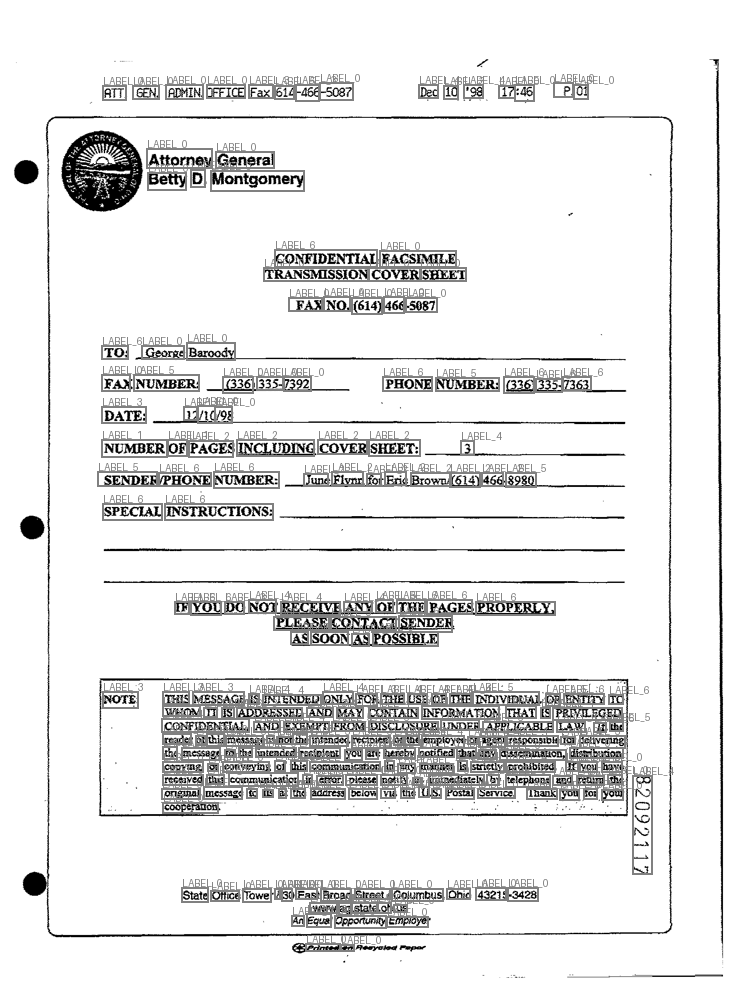

In [43]:
# Filter only predictions corresponding to real tokens
real_boxes = [box for box, label in zip(boxes, pred_labels) if label != -100]
real_words = [word for word, label in zip(words, pred_labels) if label != -100]

draw_predictions(image.copy(), real_words, real_boxes, pred_labels, title="LayoutLMv3 Predictions")


## BROS